In [1]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install tensorflow

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 4
BS = 32

In [6]:
DIRECTORY = r"S:\ML(projects)\Facemask detection Project\dataset"
CATEGORIES = ["with_mask", "without_mask"]


In [7]:
import os
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

[INFO] loading images...


C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
# perform encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)


In [9]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
input_shape = (224, 224, 3)
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)

# baseModel = MobileNetV2(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))

In [11]:
# # construct the head of the model that will be placed on top of the
# # the base model
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# # place the head FC model on top of the base model (this will become
# # the actual model we will train)
# model = Model(inputs=baseModel.input, outputs=headModel)

# # loop over all layers in the base model and freeze them so they will
# # *not* be updated during the first training process
# for layer in baseModel.layers:
# 	layer.trainable = False

In [13]:
# from tensorflow.keras.optimizers.schedules import ExponentialDecay


# # Define the learning rate schedule
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=INIT_LR,
#     decay_steps=len(trainX) // BS * 5,  # Decay learning rate every 5 epochs
#     decay_rate=0.9  # Decrease learning rate by 0.9 every decay step
# )
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(128, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(2, activation="softmax")(headModel)

# model = Model(inputs=baseModel.input, outputs=headModel)
# # Compile the model
# print("[INFO] Compiling model...")
# opt = Adam(learning_rate=lr_schedule)
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# # ...

# # Train the model
# print("[INFO] Training head...")
# H = model.fit(
#     aug.flow(trainX, trainY, batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=EPOCHS
# )


[INFO] Compiling model...
[INFO] Training head...


ValueError: `x` (images tensor) and `y` (labels) should have the same length. Found: x.shape = (224, 224, 3), y.shape = (3066, 1)

In [ ]:
from sklearn.metrics import classification_report

# ... (previous code)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# make sure testY is in one-hot encoded format
testY_onehot = to_categorical(testY)

# show a nicely formatted classification report
class_labels = lb.classes_.tolist()
class_labels = [str(label) for label in class_labels]
print(classification_report(testY_onehot.argmax(axis=1), predIdxs, target_names=class_labels))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] evaluating network...


ValueError: in user code:

    File "C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_9" expects 1 input(s), but it received 767 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:7' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:8' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:9' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:10' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:11' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:12' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:13' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:14' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:15' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:16' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:17' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:18' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:19' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:20' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:21' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:22' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:23' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:24' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:25' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:26' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:27' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:28' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:29' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:30' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:31' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:32' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:33' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:34' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:35' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:36' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:37' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:38' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:39' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:40' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:41' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:42' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:43' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:44' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:45' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:46' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:47' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:48' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:49' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:50' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:51' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:52' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:53' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:54' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:55' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:56' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:57' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:58' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:59' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:60' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:61' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:62' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:63' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:64' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:65' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:66' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:67' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:68' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:69' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:70' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:71' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:72' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:73' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:74' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:75' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:76' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:77' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:78' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:79' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:80' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:81' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:82' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:83' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:84' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:85' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:86' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:87' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:88' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:89' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:90' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:91' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:92' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:93' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:94' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:95' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:96' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:97' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:98' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:99' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:100' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:101' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:102' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:103' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:104' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:105' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:106' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:107' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:108' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:109' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:110' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:111' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:112' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:113' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:114' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:115' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:116' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:117' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:118' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:119' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:120' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:121' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:122' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:123' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:124' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:125' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:126' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:127' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:128' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:129' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:130' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:131' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:132' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:133' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:134' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:135' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:136' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:137' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:138' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:139' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:140' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:141' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:142' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:143' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:144' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:145' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:146' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:147' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:148' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:149' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:150' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:151' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:152' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:153' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:154' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:155' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:156' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:157' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:158' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:159' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:160' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:161' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:162' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:163' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:164' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:165' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:166' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:167' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:168' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:169' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:170' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:171' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:172' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:173' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:174' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:175' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:176' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:177' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:178' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:179' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:180' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:181' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:182' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:183' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:184' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:185' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:186' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:187' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:188' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:189' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:190' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:191' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:192' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:193' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:194' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:195' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:196' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:197' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:198' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:199' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:200' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:201' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:202' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:203' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:204' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:205' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:206' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:207' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:208' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:209' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:210' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:211' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:212' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:213' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:214' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:215' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:216' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:217' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:218' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:219' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:220' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:221' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:222' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:223' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:224' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:225' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:226' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:227' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:228' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:229' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:230' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:231' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:232' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:233' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:234' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:235' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:236' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:237' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:238' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:239' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:240' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:241' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:242' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:243' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:244' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:245' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:246' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:247' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:248' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:249' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:250' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:251' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:252' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:253' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:254' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:255' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:256' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:257' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:258' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:259' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:260' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:261' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:262' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:263' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:264' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:265' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:266' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:267' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:268' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:269' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:270' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:271' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:272' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:273' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:274' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:275' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:276' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:277' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:278' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:279' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:280' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:281' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:282' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:283' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:284' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:285' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:286' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:287' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:288' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:289' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:290' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:291' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:292' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:293' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:294' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:295' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:296' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:297' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:298' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:299' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:300' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:301' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:302' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:303' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:304' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:305' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:306' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:307' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:308' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:309' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:310' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:311' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:312' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:313' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:314' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:315' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:316' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:317' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:318' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:319' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:320' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:321' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:322' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:323' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:324' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:325' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:326' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:327' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:328' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:329' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:330' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:331' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:332' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:333' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:334' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:335' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:336' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:337' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:338' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:339' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:340' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:341' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:342' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:343' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:344' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:345' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:346' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:347' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:348' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:349' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:350' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:351' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:352' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:353' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:354' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:355' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:356' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:357' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:358' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:359' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:360' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:361' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:362' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:363' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:364' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:365' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:366' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:367' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:368' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:369' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:370' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:371' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:372' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:373' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:374' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:375' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:376' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:377' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:378' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:379' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:380' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:381' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:382' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:383' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:384' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:385' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:386' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:387' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:388' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:389' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:390' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:391' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:392' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:393' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:394' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:395' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:396' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:397' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:398' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:399' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:400' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:401' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:402' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:403' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:404' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:405' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:406' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:407' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:408' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:409' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:410' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:411' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:412' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:413' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:414' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:415' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:416' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:417' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:418' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:419' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:420' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:421' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:422' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:423' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:424' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:425' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:426' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:427' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:428' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:429' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:430' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:431' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:432' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:433' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:434' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:435' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:436' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:437' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:438' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:439' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:440' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:441' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:442' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:443' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:444' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:445' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:446' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:447' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:448' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:449' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:450' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:451' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:452' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:453' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:454' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:455' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:456' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:457' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:458' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:459' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:460' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:461' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:462' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:463' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:464' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:465' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:466' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:467' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:468' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:469' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:470' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:471' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:472' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:473' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:474' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:475' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:476' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:477' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:478' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:479' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:480' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:481' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:482' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:483' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:484' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:485' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:486' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:487' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:488' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:489' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:490' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:491' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:492' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:493' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:494' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:495' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:496' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:497' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:498' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:499' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:500' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:501' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:502' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:503' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:504' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:505' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:506' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:507' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:508' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:509' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:510' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:511' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:512' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:513' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:514' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:515' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:516' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:517' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:518' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:519' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:520' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:521' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:522' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:523' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:524' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:525' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:526' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:527' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:528' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:529' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:530' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:531' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:532' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:533' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:534' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:535' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:536' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:537' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:538' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:539' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:540' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:541' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:542' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:543' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:544' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:545' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:546' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:547' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:548' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:549' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:550' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:551' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:552' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:553' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:554' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:555' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:556' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:557' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:558' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:559' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:560' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:561' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:562' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:563' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:564' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:565' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:566' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:567' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:568' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:569' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:570' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:571' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:572' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:573' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:574' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:575' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:576' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:577' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:578' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:579' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:580' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:581' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:582' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:583' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:584' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:585' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:586' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:587' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:588' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:589' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:590' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:591' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:592' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:593' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:594' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:595' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:596' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:597' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:598' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:599' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:600' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:601' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:602' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:603' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:604' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:605' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:606' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:607' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:608' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:609' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:610' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:611' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:612' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:613' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:614' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:615' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:616' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:617' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:618' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:619' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:620' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:621' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:622' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:623' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:624' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:625' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:626' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:627' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:628' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:629' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:630' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:631' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:632' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:633' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:634' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:635' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:636' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:637' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:638' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:639' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:640' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:641' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:642' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:643' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:644' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:645' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:646' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:647' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:648' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:649' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:650' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:651' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:652' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:653' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:654' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:655' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:656' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:657' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:658' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:659' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:660' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:661' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:662' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:663' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:664' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:665' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:666' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:667' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:668' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:669' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:670' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:671' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:672' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:673' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:674' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:675' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:676' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:677' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:678' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:679' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:680' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:681' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:682' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:683' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:684' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:685' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:686' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:687' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:688' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:689' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:690' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:691' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:692' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:693' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:694' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:695' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:696' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:697' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:698' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:699' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:700' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:701' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:702' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:703' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:704' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:705' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:706' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:707' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:708' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:709' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:710' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:711' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:712' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:713' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:714' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:715' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:716' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:717' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:718' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:719' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:720' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:721' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:722' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:723' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:724' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:725' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:726' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:727' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:728' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:729' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:730' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:731' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:732' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:733' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:734' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:735' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:736' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:737' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:738' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:739' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:740' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:741' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:742' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:743' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:744' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:745' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:746' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:747' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:748' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:749' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:750' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:751' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:752' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:753' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:754' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:755' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:756' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:757' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:758' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:759' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:760' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:761' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:762' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:763' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:764' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:765' shape=(32, 224, 3) dtype=float32>, <tf.Tensor 'IteratorGetNext:766' shape=(32, 224, 3) dtype=float32>]


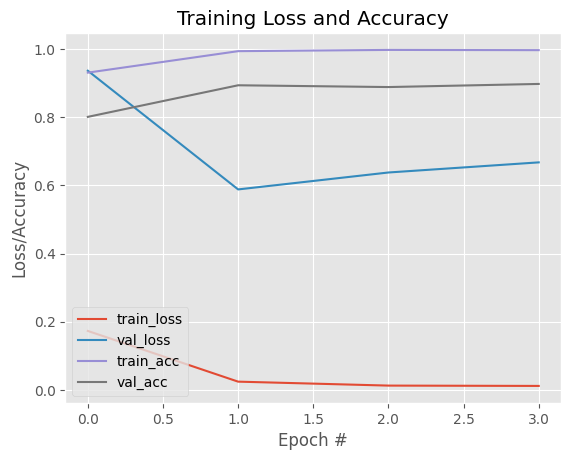

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "S:\ML(projects)\Facemask detection Project\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

[INFO] loading images...


C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


MemoryError: Unable to allocate 2.15 GiB for an array with shape (3833, 224, 224, 3) and data type float32

In [15]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"S:\ML(projects)\Facemask detection Project\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
from sklearn.metrics import classification_report

# ... (previous code)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# make sure testY is in one-hot encoded format
testY_onehot = to_categorical(testY)

# show a nicely formatted classification report
class_labels = lb.classes_.tolist()
class_labels = [str(label) for label in class_labels]
print(classification_report(testY_onehot.argmax(axis=1), predIdxs, target_names=class_labels))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

[INFO] loading images...


C:\Users\saiki\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[INFO] evaluating network...
24/24 [==============================] - 19s 721ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets